In [18]:
import sys
# Change to repository root, so it can find the config folder with the paths inside it
GITHUB_REPO_PATH = '/Users/maxwellrosen/Storage/Salk_Plant_Imaging/eckerlabproj'
# Add config folder with paths to Python's import search path
if GITHUB_REPO_PATH not in sys.path:
    sys.path.insert(0, GITHUB_REPO_PATH)

import config.paths as paths

In [19]:
# only needed in Jupyter Lab to see the images inline
%matplotlib widget

from plantcv import plantcv as pcv
from plantcv.parallel import WorkflowInputs
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import json
import shutil

In [20]:
# For grabbing the image: Finds the only file in the temp_holder
image_dir = paths.cl_image_directory
files = [f for f in os.listdir(image_dir) if not f.startswith(".")]
if len(files) == 0:
    raise FileNotFoundError(f"No files found in {image_dir}.")
elif len(files) > 1:
    print(f"Warning: More than one image in {image_dir}, using one.")
filename = files[0]
image_name = filename
print(f"Image Name: {image_name}")
image_path = os.path.join(image_dir, image_name)
# Change to Chamber folder: this is where the temporary data on pixel number in plants is saved
t1_temp_chamber_image_results = paths.t1_temp_pixel_results
t2_temp_chamber_image_results = paths.t2_temp_pixel_results
t3_temp_chamber_image_results = paths.t3_temp_pixel_results
# Change to location where data from this run is saved
analysis_results_csv_path = paths.analysis_results_csv_path
# Change to location where plant_names.csv is saved
plant_names_path = paths.plant_mapping_csv_path

Image Name: ChamberLeft_image_2025-11-05--16-50.jpg


In [21]:
# Splitting filename to get the time
name_without_ext, _ = os.path.splitext(filename)
print(name_without_ext)
name_parts = name_without_ext.split('_')
print(name_parts)
time = name_parts[2]
print(time)

ChamberLeft_image_2025-11-05--16-50
['ChamberLeft', 'image', '2025-11-05--16-50']
2025-11-05--16-50


In [22]:
# Input/output options for PlantCV
args1 = WorkflowInputs(
    images=[image_path],
    names="image1",
    result=t1_temp_chamber_image_results, 
    outdir=".",
    writeimg=False,
    debug="plot"
    )
args2 = WorkflowInputs(
    images=[image_path],
    names="image1",
    result=t2_temp_chamber_image_results, 
    outdir=".",
    writeimg=False,
    debug="plot"
    )
args3 = WorkflowInputs(
    images=[image_path],
    names="image1",
    result=t3_temp_chamber_image_results, 
    outdir=".",
    writeimg=False,
    debug="plot"
    )

Starting here, different per tray

In [23]:
# Set debug to the global parameter 
pcv.params.debug = args1.debug
# Change display settings
pcv.params.dpi = 100
# Increase text size and thickness to make labels clearer
# (size may need to be altered based on original image size)
pcv.params.text_size = 10
pcv.params.text_thickness = 20

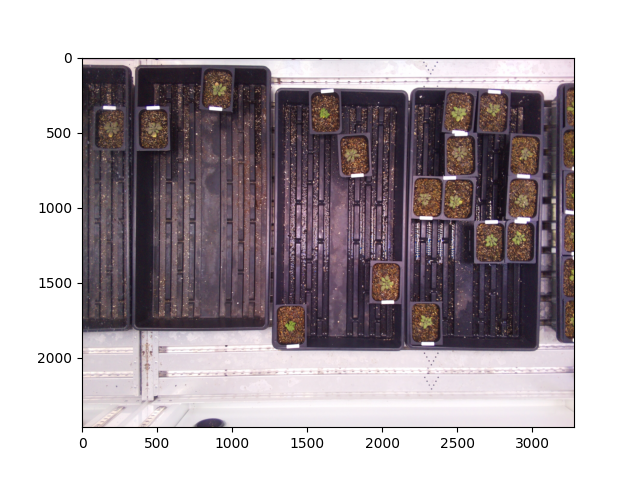

In [26]:
# Shows your image, defines it as "img"
img1, path, filename = pcv.readimage(filename=args1.image1)

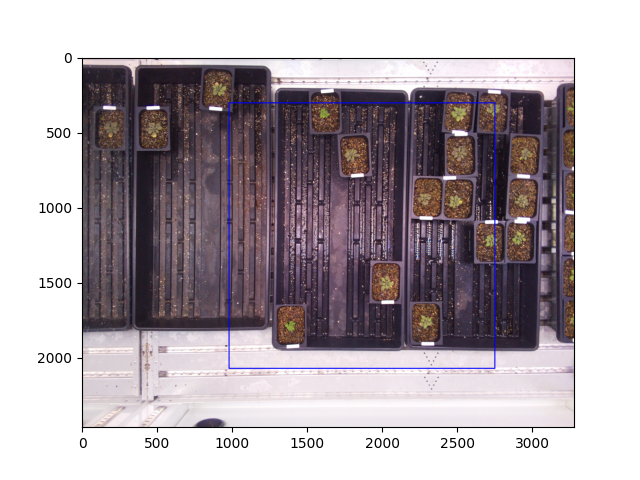

In [27]:
# Crops your image
crop_img1 = pcv.crop(img=img1, x=980, y=305, w=1773, h=1769)

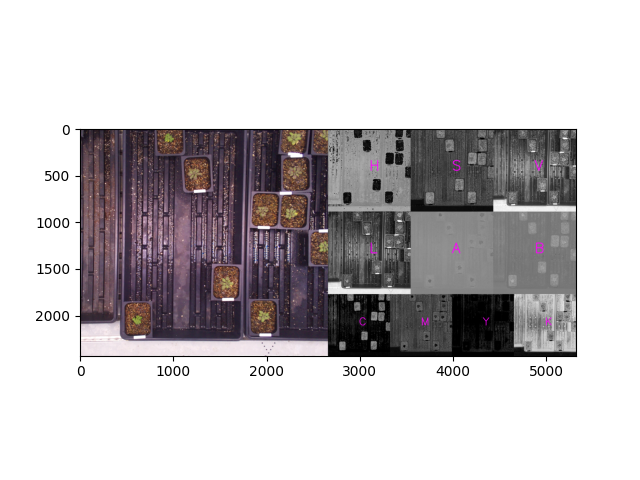

In [28]:
# Shows options for which channel to view the image through (ideally want the most contrast)
colorspace_img1 = pcv.visualize.colorspaces(rgb_img=crop_img1)

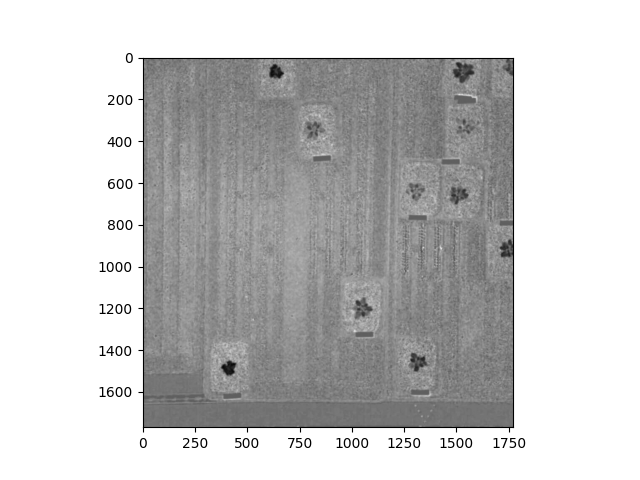

In [32]:
# Actually picks a channel with rgb2gray_"lab" and then the channel is the letter from "lab" that you look through
channeled_img1 = pcv.rgb2gray_lab(rgb_img=crop_img1, channel='a')

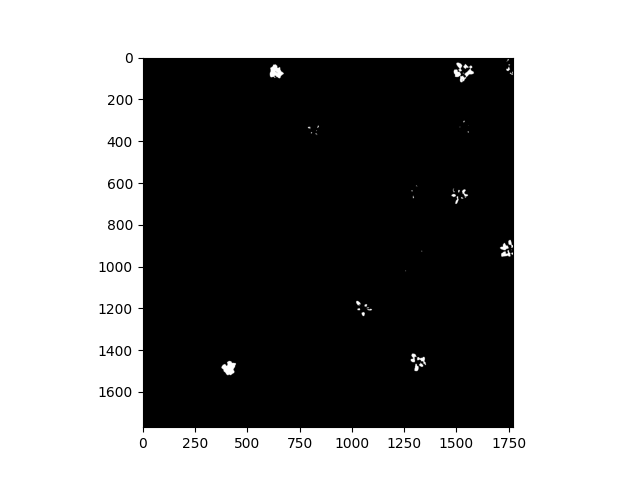

In [35]:
# Masks the image
thresh_mask1 = pcv.threshold.binary(gray_img=channeled_img1, threshold=120, object_type='dark')

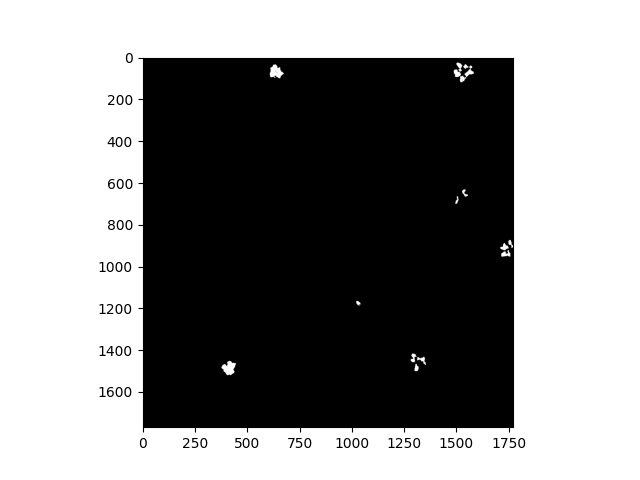

In [36]:
# Deletes groups of pixels less than the pixel size (weird dots around edges not plant is unmasked)
cleaned_mask1 = pcv.fill(bin_img=thresh_mask1, size=250)

In [37]:
# Defines many Region of Interests (ROI) which selects white pixels and deselects black pixels from a masked image, based from little circles around each plant with coordinates we define
rois1 = pcv.roi.multi(img=cleaned_mask1, 
                    coord=[(82,168), (307,153), (503,163), (738,158), 
                           (1049,186), (1264,196), (1460,196), (1657,172), 
                           (106,483), (292,426), (517,459), (728,469), 
                           (1030,488), (1211,507), (1438,526), (1642,507), 
                           (91,766), (302,747), (508,751), (723,785), 
                           (996,804), (1192,761), (1441,751), (1654,814), 
                           (77,1034), (312,1039), (506,1039), (723,1034), 
                           (986,1072), (1202,1077), (1446,1086), (1659,1110), 
                           (101,1331), (321,1345), (522,1321), (723,1297), 
                           (972,1331), (1192,1369), (1393,1393), (1599,1393), 
                           (96,1601), (972,1607)],
                    radius=30)

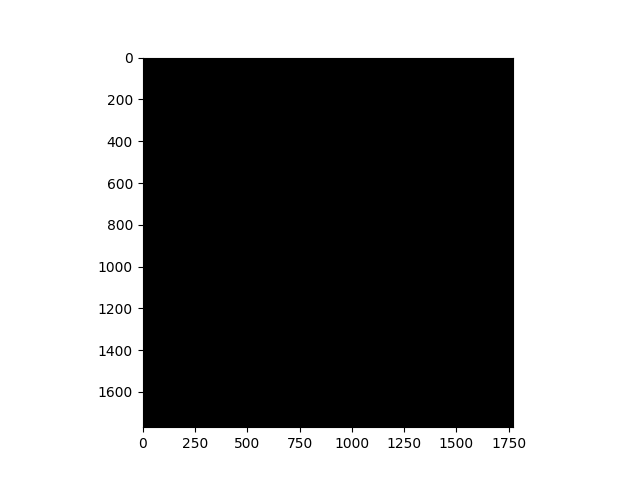

In [38]:
# Label and number objects in ROI; A good check to ensure different plants are different objects from being different colors
labeled_mask1, num_plants1 = pcv.create_labels(mask=cleaned_mask1, rois=rois1, roi_type='partial')

In [39]:
# Outputs analyzed image
shape_image1 = pcv.analyze.size(img=crop_img1, labeled_mask=labeled_mask1, n_labels=num_plants1)

In [40]:
# Saves results for the 1 image (running again overwites past results)
pcv.outputs.save_results(filename= args1.result, outformat="json")

Above this is per tray

In [19]:
scale_values_path = paths.t1_scale_values_path
# Gets pixels to mm scalar s (mm per pixel, so: pixels * s^2 = mm^2)
with open(scale_values_path, "r") as f:
    scale_data = json.load(f)

mean_s = scale_data["mean_scale_mm_per_pixel"]
std_s = scale_data["std_scale_mm_per_pixel"]

In [20]:
# Create single-row DataFrame and write it to an analysis results csv
df = pd.read_csv(plant_names_path)
for i in list(range(1,43)): # starts at first number, goes up to but not including second number
    pixels_value = pcv.outputs.observations[f"default_{i}"]["area"]["value"]
    plant_number = f"plant{i}"
    plant_ID = df.loc[df["old_plant_number"] == plant_number, "new_name"].values[0]
    stress = df.loc[df["old_plant_number"] == plant_number, "stress"].values[0]
    new_data = pd.DataFrame([{
        "time": time,
        "plant_number": plant_number,
        "tray_number": tray_number,
        "plant_ID": plant_ID,
        "Area (mm^2)": pixels_value * (mean_s ** 2),
        "Stress (%)": stress
        # "Uncertainty (mm^2)": pixels_value * 2 * mean_s * std_s
    }])
    # If analysis_log.csv doesn't exist, creates it with a header:
    if not os.path.isfile(analysis_results_csv_path):
        new_data.to_csv(analysis_results_csv_path, index=False)
    else:
        # Append without writing header again
        new_data.to_csv(analysis_results_csv_path, mode='a', header=False, index=False)

In [21]:
# Moves image to longterm storage
short_term_dir = '/Users/maxwellrosen/Library/CloudStorage/GoogleDrive-salkimager@gmail.com/My Drive/Chamber/Temp_C1_Holder'
long_term_dir = '/Users/maxwellrosen/Library/CloudStorage/GoogleDrive-salkimager@gmail.com/My Drive/Chamber/Longterm_Image_Storage'
filename = image_name

# Full paths
src_path = os.path.join(short_term_dir, filename)
dst_path = os.path.join(long_term_dir, filename)

# Ensure long-term folder exists
os.makedirs(long_term_dir, exist_ok=True)

# Moves file to long-term folder
shutil.move(src_path, dst_path)

'/Users/maxwellrosen/Library/CloudStorage/GoogleDrive-salkimager@gmail.com/My Drive/Chamber/Longterm_Image_Storage/Chamber1_image_2025-10-31--15-30.jpg'

In [22]:
plt.close('all')

In [1]:
# Unused because too complicated to write in a new name column each time


# # Adds column with plant names ("plant1" next to "Col")
# # Loads CSV with plant areas
# df = pd.read_csv(analysis_results_csv_path)

# # Loads name map (old_name -> new_name)
# map_df = pd.read_csv(plant_names_path)

# # Merge mapping to get the plant_name column (left_on takes left column, right_on takes right column, how keeps left dataframe intact)
# df = df.merge(map_df, left_on="plant_number", right_on="old_plant_number", how="left")

# # Renames column of plant names that we inputted (read as "new_name") into "plant_name" on the csv
# df = df.rename(columns={"new_name": "plant_name"})

# # Drops the "old_plant_number" column because it's unneeded
# df = df.drop(columns=["old_plant_number"])

# # Reorders csv to how we want it (use correct column titles or else Pandas will raise a KeyError)
# df = df[["plant_number", "plant_name", "Area (mm^2)", "Uncertainty (mm^2)"]]

# # Saves renamed file - if change to a different path, can save it to a new "renamed_output_data.csv" file
# df.to_csv(analysis_results_csv_path, index=False)

In [21]:
# Not used because it's too complex and trying to make a mask of only plants is too difficult, when we can use a cluttered mask but only scan the plants:

# # Runs through all ROIs and shapes them

# img_copy = np.copy(crop_img)

# # The result file should exist if plantcv-workflow.py was run
# if os.path.exists(args.result):
#     # Open the result file
#     results = open(args.result, "r")
#     # The result file would have image metadata in it from plantcv-workflow.py, read it into memory
#     metadata = results.read()
#     # Close the file
#     results.close()
#     # Delete the file, we will create new ones
#     os.remove(args.result)

# for i in range(0, 48):
#     roi = rois[i]
#     hierarchy = roi_hierarchy[i]
#     # Find objects
#     filtered_contours, filtered_hierarchy, filtered_mask, filtered_area = pcv.roi_objects(
#         img=crop_img, roi_type="partial", roi_contour=roi, roi_hierarchy=hierarchy, object_contour=obj, 
#         obj_hierarchy=obj_hierarchy)

#     # Combine objects together in each plant     
#     plant_contour, plant_mask = pcv.object_composition(img=crop_img, contours=filtered_contours, hierarchy=filtered_hierarchy)        

#     # Analyze the shape of each plant 
#     analysis_images = pcv.analyze_object(img=img_copy, obj=plant_contour, mask=plant_mask)

#     # Save the image with shape characteristics 
#     img_copy = analysis_images

#     # Print out a text file with shape data for each plant in the image 
#     filename = args.result[:-4] + "_" + str(i) + ".txt" 
#     with open(filename, "w") as r:
#         r.write(metadata)
#     pcv.print_results(filename=filename)
#     # Clear the measurements stored globally into the Outputs class
#     pcv.outputs.clear()

In [22]:
# If you have beautiful plants in rows and columns and too lazy to individually make coordinates for each plant, use automatic ROI making:

# # Make new ROI's to select the different plants (use/change this for rows and columns of plants)
# auto_rois = pcv.roi.auto_grid(mask=kept_mask, nrows=6, ncols=8, img=crop_img)

In [23]:
# Only if you can have 1 ROI for all plants (easier for desktop imaging)

# # Makes a new mask only with plants inside ROI

# # Inputs for the filtering function:
# #    mask            = the clean mask you made above
# #    roi            = the region of interest you specified above
# #    roi_type       = 'partial' (default, for partially inside the ROI then still keeps whole plant if some lies outside ROI), 'cutto' (hard cut off), or 
# #                     'largest' (keep only largest object)

# kept_mask  = pcv.roi.filter(mask=cleaned_mask, roi=roi, roi_type='partial')